# Logistic Regression with Undersampling/oversampling
@hyyoka

## Data 

출처 : https://www.kaggle.com/mlg-ulb/creditcardfraud


* V1 ~ V28 : 비식별화 된 개인정보 
* **Class** : Target 변수  
  - 1 : fraudulent transactions (사기)
  - 0 : otherwise 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("assignment3_creditcard.csv")

In [ ]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.848212,2.384900,0.379573,1.048381,-0.845070,2.537837,-4.542983,-10.201458,-1.504967,-2.234167,0.394940,1.935899,-0.359235,1.822466,-0.054693,0.857551,-0.053336,0.529098,0.159752,2.585817,-5.291690,0.859364,0.423231,-0.506985,1.020052,-0.627751,-0.017753,0.280982,0
1,2.071805,-0.477943,-1.444444,-0.548657,0.010036,-0.582242,-0.042878,-0.247160,1.171923,-0.342382,-1.159036,0.719861,0.622591,-0.157846,-0.373298,-0.515740,-0.117206,-0.569763,0.644970,-0.077306,0.042858,0.390125,0.041569,0.598427,0.098803,0.979686,-0.093244,-0.065615,0
2,-2.985294,-2.747472,1.194068,-0.003036,-1.151041,-0.263559,0.553500,0.635600,0.438545,-1.806488,-0.703073,0.588971,-0.146823,-0.181353,-0.690156,-0.028327,0.410035,-0.828869,-0.885471,1.345776,0.373760,-0.385777,1.197596,0.407229,0.008013,0.762362,-0.299024,-0.303929,0
3,-1.479452,1.542874,0.290895,0.838142,-0.529290,-0.717661,0.484516,0.545092,-0.780767,0.324804,1.136838,0.648191,-0.468076,1.016010,0.206836,-0.138604,-0.066788,0.459306,0.663398,0.038397,0.116771,0.405560,-0.116453,0.541275,-0.216665,-0.415578,0.027126,-0.150347,0
4,-0.281976,-0.309699,-2.162299,-0.851514,0.106167,-1.483888,1.930994,-0.843049,-1.249272,1.079608,-1.352709,-0.995678,-0.887039,0.732821,-0.557246,-2.412225,0.200509,0.823963,-0.531789,-0.875516,-0.004199,1.015108,-0.026748,0.077115,-1.468822,0.751700,0.496732,0.331001,0


In [ ]:
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000
mean,-0.015438,0.053653,-0.046031,0.037348,-0.033724,-0.003299,-0.051054,0.006064,-0.018530,-0.041149,0.033738,-0.047544,0.014048,-0.053556,-0.011562,-0.031559,-0.045020,-0.005966,0.007183,0.002633,0.010289,-0.000656,-0.004800,-0.000897,-0.001989,-0.000765,0.000948,0.001535,0.008578
std,2.031529,1.616186,1.758169,1.482109,1.486998,1.339259,1.454827,1.364342,1.134065,1.252593,1.096583,1.208918,0.995720,1.193859,0.916783,1.000876,1.186014,0.892478,0.827420,0.720307,0.847152,0.739469,0.593663,0.603349,0.517968,0.483852,0.397075,0.296736,0.092221
min,-30.552380,-42.172688,-31.103685,-5.560118,-42.147898,-21.929312,-41.506796,-39.267378,-13.434066,-24.403185,-4.339319,-18.431131,-3.844974,-19.214325,-3.894020,-13.303888,-24.019099,-9.335193,-4.619034,-21.387122,-21.453736,-8.887017,-36.666000,-2.718024,-6.712624,-2.241620,-7.418878,-9.617915,0.000000
25%,-0.916927,-0.575381,-0.899872,-0.843321,-0.714901,-0.763757,-0.568146,-0.206103,-0.661909,-0.543450,-0.748920,-0.421077,-0.633399,-0.449537,-0.597618,-0.478844,-0.494037,-0.497440,-0.459073,-0.209678,-0.225520,-0.539244,-0.160583,-0.356047,-0.318619,-0.327343,-0.070558,-0.052189,0.000000
50%,0.020050,0.075358,0.180610,-0.008844,-0.060040,-0.271363,0.036107,0.022463,-0.055095,-0.097390,-0.010467,0.137410,-0.003826,0.037809,0.041502,0.059667,-0.067213,-0.000928,0.002111,-0.062792,-0.028778,0.007302,-0.011199,0.040006,0.019770,-0.056260,0.002049,0.011075,0.000000
75%,1.317461,0.806957,1.029928,0.771958,0.613328,0.397269,0.559409,0.329606,0.605704,0.460681,0.760396,0.612790,0.675571,0.485859,0.637263,0.517753,0.403942,0.514982,0.467781,0.131199,0.184312,0.526358,0.146835,0.437146,0.352717,0.240713,0.091637,0.078911,0.000000
max,2.399484,21.467203,4.069865,11.927512,32.911462,22.529298,36.677268,20.007208,8.113152,15.236028,12.018913,4.574082,3.685570,7.667726,3.680272,6.098529,9.207059,4.054462,5.228342,26.237391,27.202839,8.361985,9.637187,3.948061,2.510401,3.122747,11.135740,14.929133,1.000000


mean을 확인한 결과, Class가 큰 폭으로 치우쳐져 있다는 생각이 들었다. 따라서, 확인해보았다. 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import pyplot
from numpy import where
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#fraud vs. normal transactions 
counts = data.Class.value_counts()

Text(0.5, 0, '(0:Non-Fraudulent, 1:Fraudulent)')

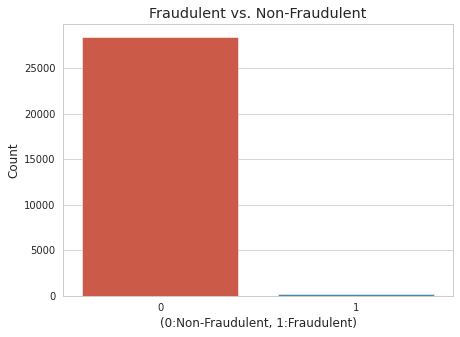

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(x=counts.index, y=counts)
plt.title('Fraudulent vs. Non-Fraudulent')
plt.ylabel('Count')
plt.xlabel('(0:Non-Fraudulent, 1:Fraudulent)')

확인한 결과, 데이터가 매우 imbalanced 되어있다는 것을 확인했다. 이는 모델의 성능에 부정적인 영향을 끼칠 수 있으므로 후에 개선한다. 

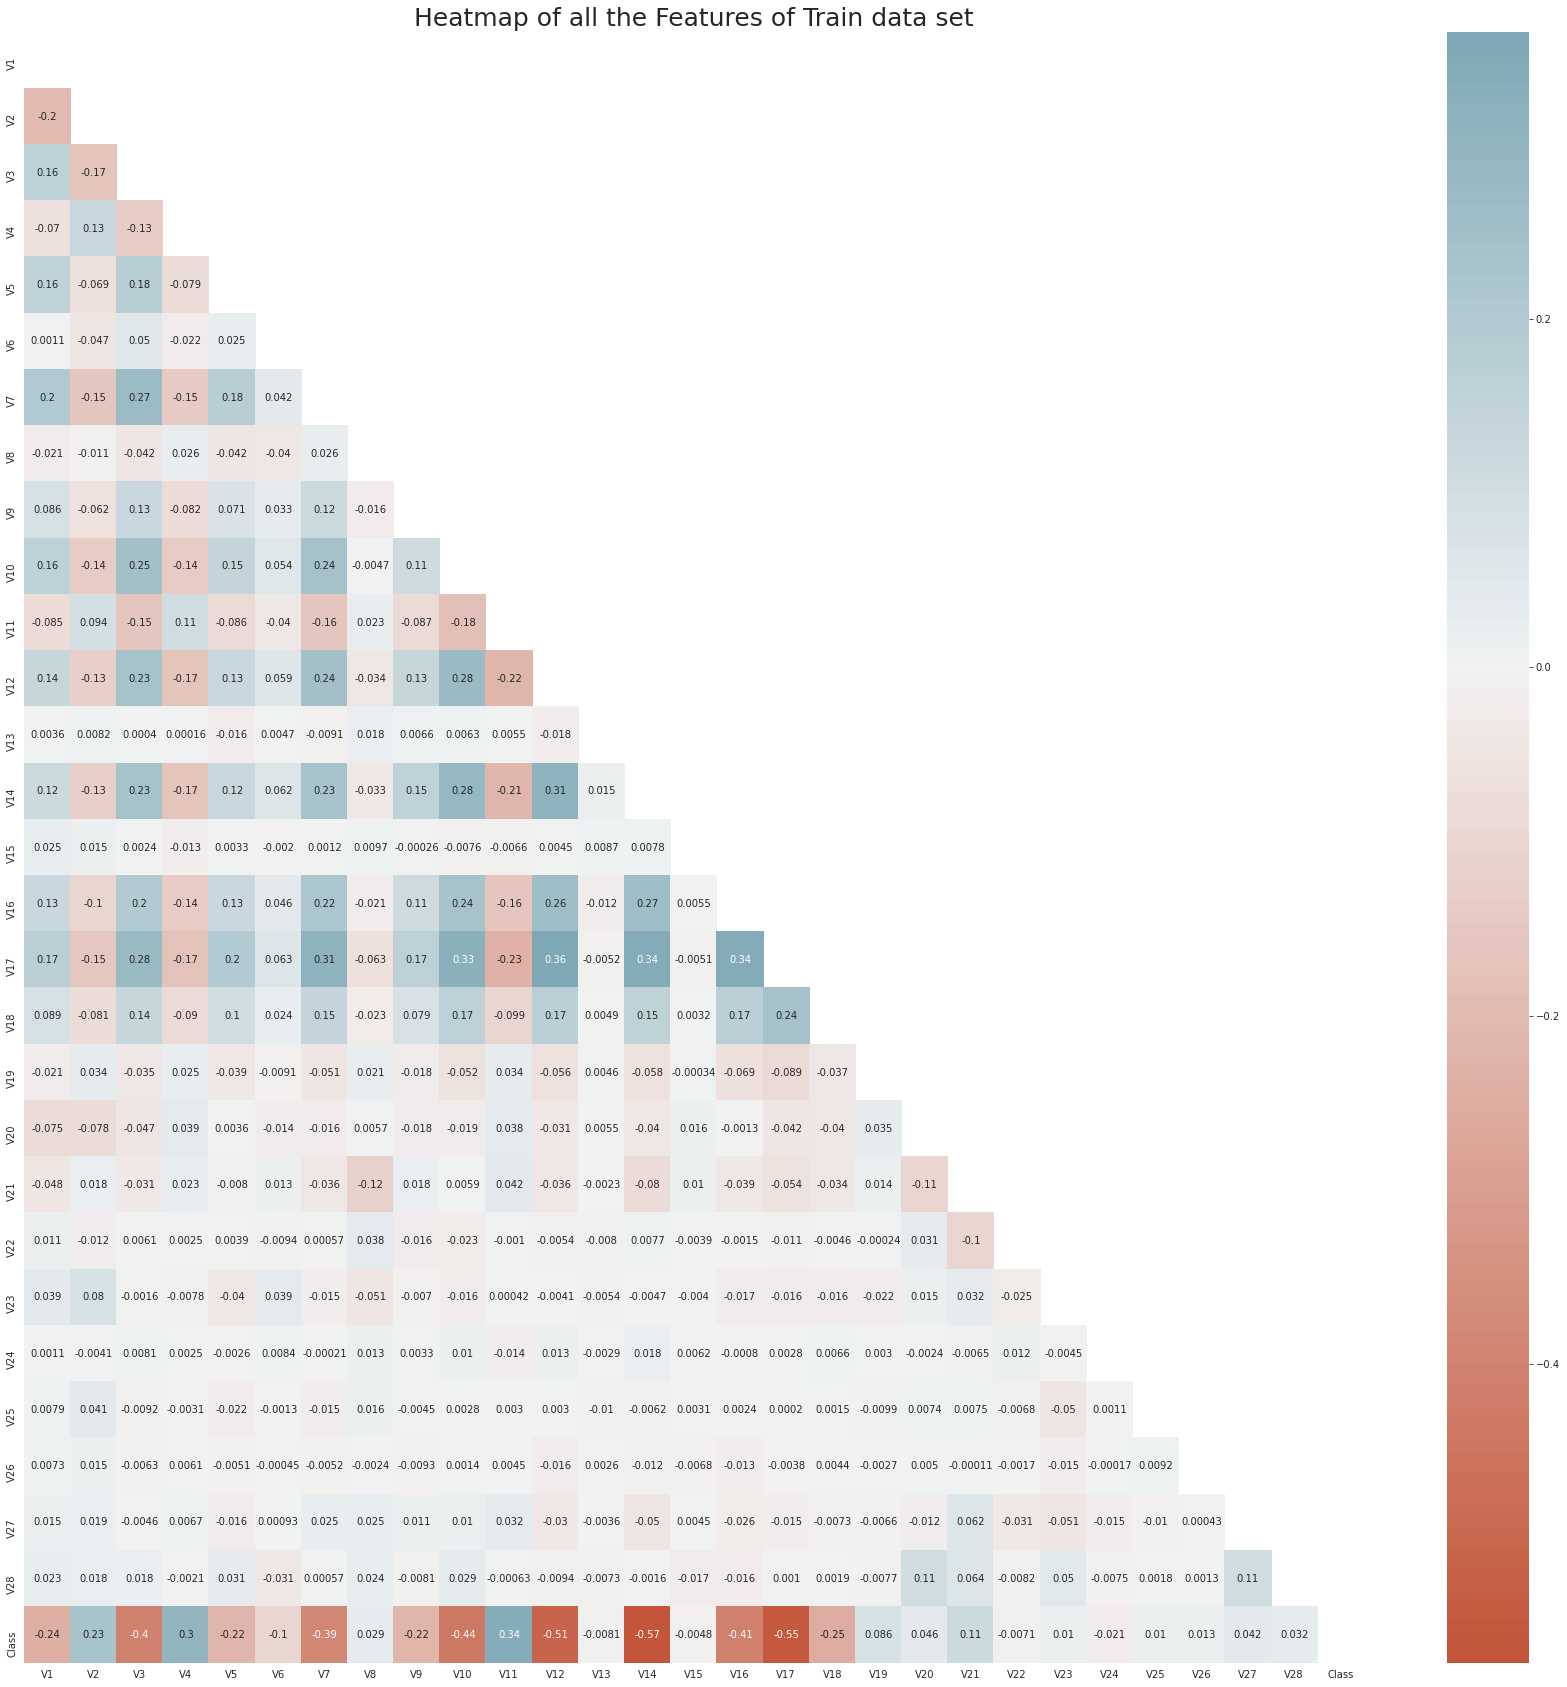

In [ ]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
## Plotting heatmap. Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

다음으로는 우리의 타겟 데이터인 "Class"와 다른 변수들의 관계를 파악했다. 신기한 것은, Class가 1로 분류되는데 긍정적인 영향을 끼치는 변수들의 수가 적을 뿐만 아니라 부정적인 영향을 끼치는 변수들의 상관성에 비해 상관성이 매우 약하다는 것이다. 

대표적으로 Positive Correlations을 가지는 V2, V4, V11의 경우 각각 0.23, 0.3, 0.34 정도에 그치는 반면, Negative Correlations를 가지는 V17, V14, V12는 -0.55, -0.57, -0.51의 높은 상관성을 지녔다. 

이는 데이터의 불균형성에 기인한 것으로 보이므로, balancing 작업 후에 heatmap을 다시 확인하도록 한다. 

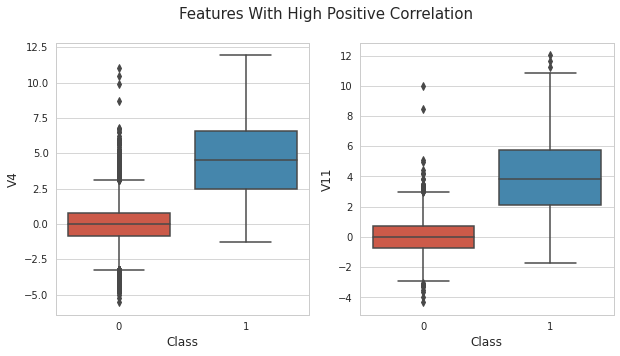

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

f.suptitle('Features With High Positive Correlation', size=15)
sns.boxplot(x="Class", y="V4", data=data, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=data, ax=axes[1])

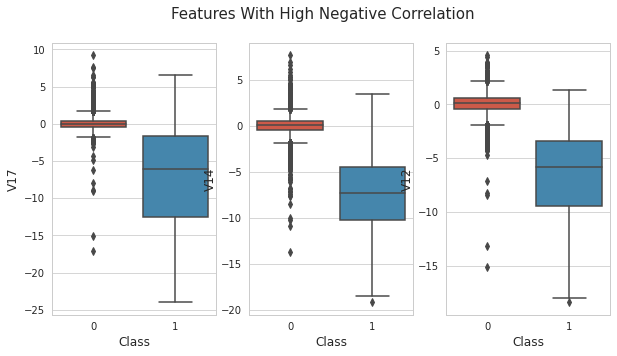

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))

f.suptitle('Features With High Negative Correlation', size=15)
sns.boxplot(x="Class", y="V17", data=data, ax=axes[0])
sns.boxplot(x="Class", y="V14", data=data, ax=axes[1])
sns.boxplot(x="Class", y="V12", data=data, ax=axes[2])

## Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report, accuracy_score, f1_score, precision_recall_curve,auc,roc_auc_score,roc_curve

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X=data.drop(columns=['Class']).values
y=data['Class'].values

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

모델의 성능을 평가하는 지표에는 여러가지가 있다. 대표적인 것은 다음과 같다:
- Accuracy = (TP+TN)/total: 정답의 비율
- Precision = TP/(TP+FP) : 결과에 얼마나 책임질 수 있나
- Recall = TP/(TP+FN) : Positive에 얼마나 민감하나
- F-score = 2\*Recall\*Precision / Recall + Precision : 둘 중 하나라도 심각하게 결과가 나쁘면 총 결과가 나쁨; 결과에도 책임지고 Positive에도 민감

우리가 사용하는 데이터가 현재 매우 imbalanced하므로 성능 평가 지표로 Accuracy를 사용하는 것은 옳지 않다. 전체를 0으로 예측해도 정확도는 그리 나쁘지 않기 때문이다. 따라서, 다른 3개의 지표를 통해 모델의 성능을 평가한다. 

In [ ]:
print(accuracy_score(y_test, y_pred))

0.9979775437617686


예상대로 Accuracy는 매우 높다. 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14232
           1       0.93      0.79      0.85       107

    accuracy                           1.00     14339
   macro avg       0.97      0.89      0.93     14339
weighted avg       1.00      1.00      1.00     14339



확인 결과, Recall은 0.79, Precision은 0.93, f-score는 0.85로 그다지 높지 않은 결과가 나왔다. 

f-score가 낮은 이유는 Recall이 꽤나 낮은 점수가 나왔기 때문이라고 해석 가능하다. 즉, 해당 모델은 Positive에 대한 민감도에 문제가 있다. 

In [ ]:
confusion_matrix(y_test,y_pred)

array([[14226,     6],
       [   23,    84]])

더 정확한 결과를 확인하기 위해 Matrix를 확인해보았다. 

- 14226: TP; ground Truth=1 && Prediction=1
- 6: FN; ground Truth=1 && Prediction=0
- 23: FP; ground Truth=0 && Prediction=1
- 84: TN; ground Truth=0 && Prediction=0


## ROC curve

ROC curve는 모델의 분별력을 나타내는 좋은 지표로, (1-specificity = FP rate, recall=TP rate)을 decision threshold와 함께 plot한 것이다. AUC는 ROC curve 밑의 면적으로, ROC의 분별력을 요약하는 성능의 지표가 된다. 

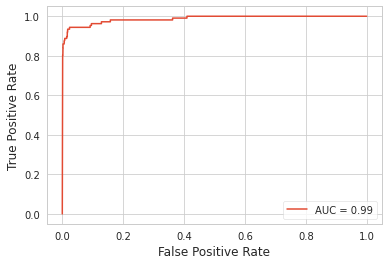

In [ ]:
# Auc Roc Curve
def generate_auc_roc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label='AUC = %0.2f'% auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')   
    plt.legend(loc=4)
    plt.show()

generate_auc_roc_curve(model, X_test, y_test)

ROC curve의 목표는 (0,1)에 최대한 가까운 그래프를 그리는 것이다. 이는 자연스럽게 AUC값이 커지는 결과로 이어진다. 해당 모델에서 AUC값은 0.97로 꽤나 높다는 것을 확인할 수 있다. 

# Undersampling

앞서, 데이터의 imbalanced 문제를 해결해야한다고 언급했다. 이를 해결하기 위해 두 가지 방법을 도입했다. 
1. Undersampling
2. Oversampling

각각을 적용한 뒤, 비교하도록 한다. 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

UnSample = RandomUnderSampler()
X_UnSample, y_UnSample = UnSample.fit_resample(X, y)

In [ ]:
X_UnSample = pd.DataFrame(X_UnSample)
y_UnSample = pd.DataFrame(y_UnSample)
y_UnSample.value_counts()

1    246
0    246
dtype: int64

Text(0.5, 0, '(0:Non-Fraudulent, 1:Fraudulent)')

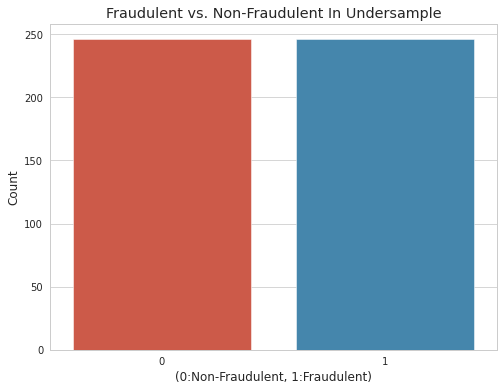

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x=[0,1], y=y_UnSample.value_counts())
plt.title('Fraudulent vs. Non-Fraudulent In Undersample')
plt.ylabel('Count')
plt.xlabel('(0:Non-Fraudulent, 1:Fraudulent)')

랜덤하게 긱 246개의 데이터를 추출함으로써, 0 레이블과 1 레이블의 비율을 5:5로 맞추었다. 

In [ ]:
df = pd.concat([X_UnSample,y_UnSample], axis=1)
df.columns =  data.columns
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-2.432206,0.816247,1.516502,0.306429,-1.427483,-0.359251,-0.604605,1.122082,0.563135,-0.424372,-1.321426,-0.277346,-1.185466,0.213708,0.213226,0.341673,0.264575,0.155087,0.134505,0.054237,-0.110869,-0.191414,-0.016802,0.390780,0.370382,0.389362,0.316163,0.079937,0
1,0.273811,0.818238,-0.482066,-1.431766,1.116186,-1.715000,1.922788,-1.114173,-0.025646,0.033882,-0.479515,0.030953,0.392501,0.096448,0.211106,-0.965381,-0.395234,-0.660321,0.669812,0.030819,0.178205,0.904679,-0.171664,0.159719,-1.008819,0.761673,-0.454752,-0.214994,0
2,0.703069,-1.794655,-0.842245,-1.996337,-1.051528,-1.077770,0.417841,-0.388540,-0.455142,-0.224708,1.211736,1.052420,0.422308,0.664064,0.623728,-1.927035,-0.107039,1.318405,0.540484,0.314709,-0.436754,-1.620690,-0.240820,-0.004163,0.249196,-0.327263,-0.076656,0.066761,0
3,-0.661757,1.022429,-1.451570,-0.238760,3.605146,3.589313,0.936306,0.465618,-0.310905,0.788417,-0.228314,-0.240025,-0.479645,0.274603,0.146073,-1.384449,-0.109837,-0.462338,0.728240,0.158176,0.031019,0.576054,-0.277452,0.717527,-0.003295,-0.477112,-0.571769,-0.467918,0
4,-0.923879,-0.321854,1.809654,-0.347741,1.606855,4.995683,-0.868936,0.789837,0.559201,1.665283,-1.160319,-0.333528,-0.075838,-1.876380,-1.068641,-2.545041,0.189828,1.629182,0.970458,0.374354,-0.759719,-0.603278,-0.353847,0.994438,0.485506,-0.138607,0.131251,-0.297279,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,0.288029,0.965681,-1.459495,1.921863,-1.912414,-1.130282,-2.814263,0.648663,-0.695263,-3.465689,2.351619,-3.826705,-0.767570,-4.852867,1.664863,-2.617361,-4.835558,-1.921752,-0.385884,0.330917,0.603127,0.380690,-0.064125,0.271380,0.337220,0.626156,0.565125,0.305925,1
488,0.016828,2.400826,-4.220360,3.462217,-0.624142,-1.294303,-2.986028,0.751883,-1.606672,-5.974925,3.264922,-5.095032,0.307808,-10.018106,0.273283,-3.562534,-4.377106,-1.792635,0.080281,0.590418,0.285832,-0.771508,-0.265200,-0.873077,0.939776,-0.219085,0.874494,0.470434,1
489,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1
490,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,-4.659330,-14.924655,8.389142,-16.465504,0.338517,-14.224404,0.556584,-11.683998,-15.841616,-5.753200,3.813041,-0.810146,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,1


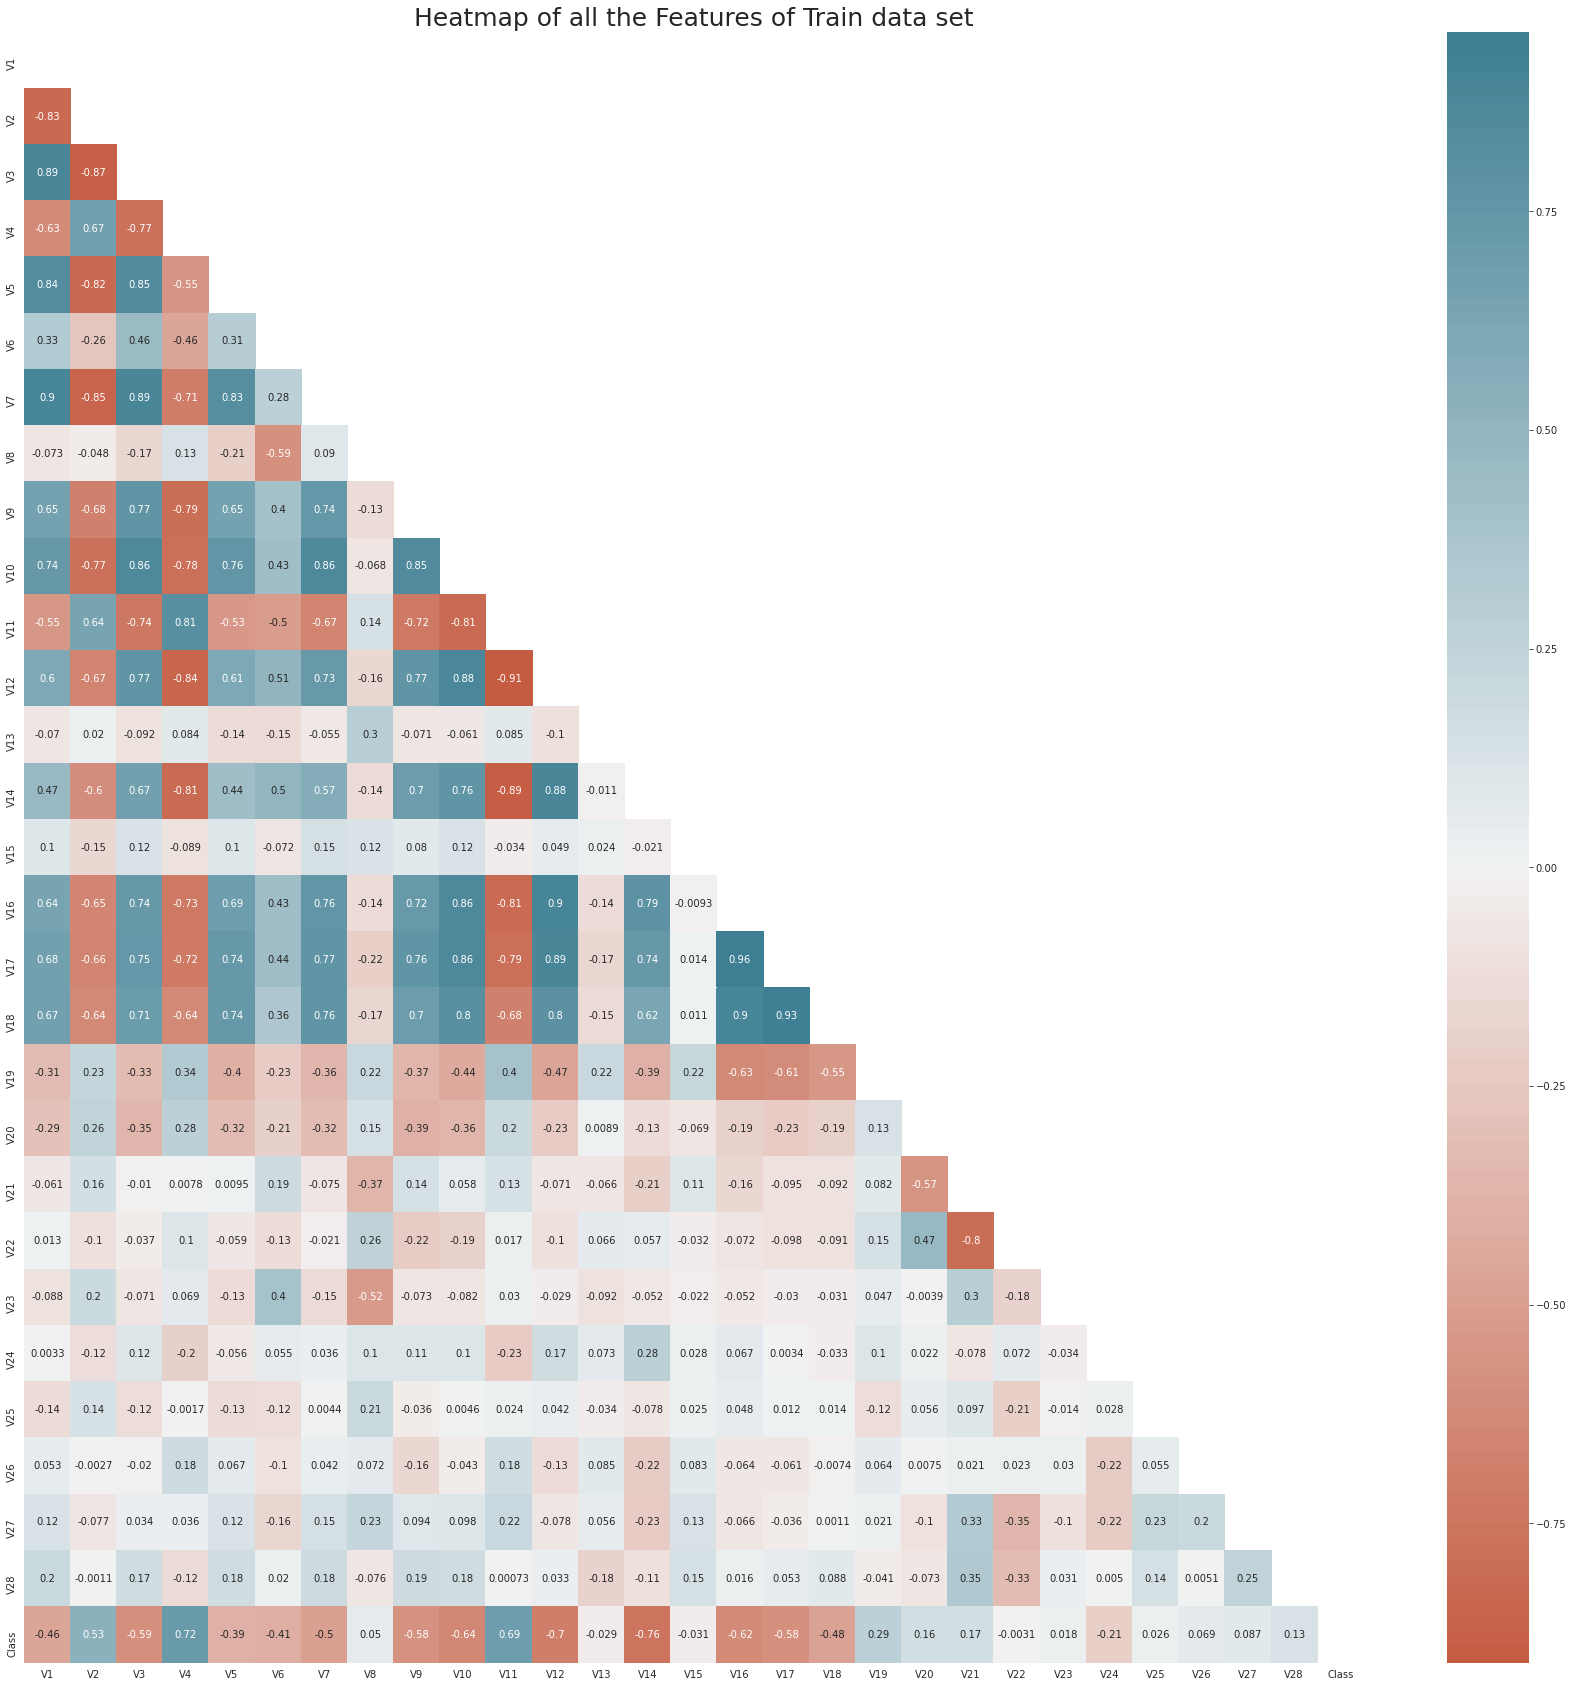

In [ ]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
## Plotting heatmap. Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25);

Correlation을 다시 확인해본 결과, imbalanced 되었을 때와는 확연히 다른 값이 나왔다. 우선, Positive Correlation을 가지던 변수들의 상관성이 크게 늘었다. V4:0.72, V11:0.69, V2:0.52로 큰 폭 증가했다. 

In [ ]:
X_un_train, X_un_test, y_un_train, y_un_test = train_test_split(X_UnSample, y_UnSample, test_size=0.2, random_state=2)

In [ ]:
model.fit(X_un_train, y_un_train)
y_pred = model.predict(X_un_test)

accuracy = accuracy_score(y_un_test, y_pred)
print("Accuracy: %.3f%%" % (accuracy))

Accuracy: 0.899%


비율을 5:5로 맞추니 Accuracy가 자연스레 떨어지는 것을 확인할 수 있다. 그리고, imbalanced data와는 다르게, Accuaracy도 유의미한 성능 지표가 된다. 

In [ ]:
print(classification_report(y_un_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90        51
           1       0.91      0.88      0.89        48

    accuracy                           0.90        99
   macro avg       0.90      0.90      0.90        99
weighted avg       0.90      0.90      0.90        99



Undersampling 결과, 0과 1에 대한 성능 지표들이 치우치지 않고 잘 분배되었다는 것을 확인할 수 있다. 특히 recall값이 큰 폭 상승해 f-scrore가 좋아졌다는 점이 주목할 만하다. 

In [ ]:
# confusion_matrix
confusion_matrix(y_un_test,y_pred)

array([[47,  4],
       [ 6, 42]])

마찬가지로, Matirx를 살펴보면 값이 이전과 같이 TP만 큰 것이 아니라 TN 값과 비슷하다는 것을 확인할 수 있다. 

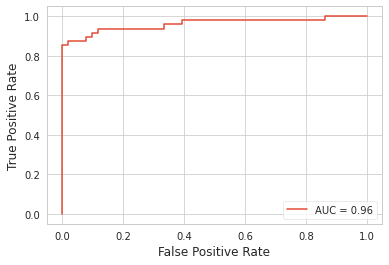

In [ ]:
generate_auc_roc_curve(model, X_un_test, y_un_test)

안타깝게도 AUC값은 소폭 감소했다. 이는 데이터의 수가 절대적으로 줄어든 점 + TP rate가 떨어진 것이 이유일 듯하다. 

# OverSampling

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

X_sm = pd.DataFrame(X_sm)
y_sm = pd.DataFrame(y_sm)

In [ ]:
y_sm.value_counts()

1    14200
0    14200
dtype: int64

Text(0.5, 0, '(0:Non-Fraudulent, 1:Fraudulent)')

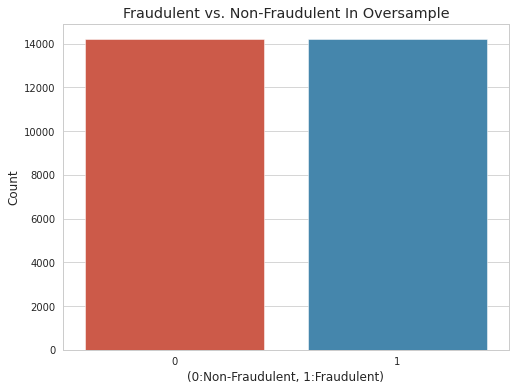

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x=[0,1], y=y_sm.value_counts())
plt.title('Fraudulent vs. Non-Fraudulent In Oversample')
plt.ylabel('Count')
plt.xlabel('(0:Non-Fraudulent, 1:Fraudulent)')

UnderSampling에서 ROC-AUC 값이 좋지 않았던 이유를 "데이터의 수 부족"에서 찾았기 때문에, 이번에는 SMOTE 방식을 이용해 Oversampling을 해보았다. 각각 14200개의 데이터를 가진 5:5 비율의 데이터를 생성했다. 

In [ ]:
df = pd.concat([X_sm,y_sm], axis=1)
df.columns =  data.columns
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,2.117785,-1.865673,-0.038505,-1.572602,-1.928395,0.224626,-1.969514,0.268185,-0.699485,1.643154,0.450906,-0.485576,-0.360529,-0.559116,-0.480476,0.155069,0.115927,0.905823,-0.050538,-0.361656,-0.082576,0.120887,0.351920,0.710426,-0.608875,-0.302625,0.044822,-0.027389,0
1,2.047191,0.099059,-1.843064,0.214140,0.679645,-0.328517,0.102703,-0.083359,0.215139,-0.220307,0.839595,0.866197,0.342293,-0.727956,-0.498858,0.611218,0.067240,0.277416,0.482370,-0.100940,-0.330872,-0.881679,0.271126,0.108052,-0.229566,0.176225,-0.066266,-0.042786,0
2,-2.830177,-2.023051,1.008751,-2.133151,-1.422501,0.259722,0.788012,0.793540,1.009187,-2.275710,0.683378,0.606071,-1.115740,0.453201,0.406315,0.096056,-0.232391,0.684272,-0.029522,1.252188,0.456561,0.123023,0.866680,-0.341888,0.575017,-0.109052,0.027327,-0.087053,0
3,-1.913675,1.678326,-0.949002,-0.699536,0.211417,0.419873,0.028026,1.393590,-0.419864,-2.370113,-0.353924,0.916642,0.462552,-0.691707,0.136792,-0.633184,2.339023,-1.234857,-1.127971,-0.533652,0.054072,0.000378,-0.038832,-1.126677,-0.091362,-0.011045,-0.439448,-0.097121,0
4,1.687084,-1.143533,-0.090635,0.495346,-0.996643,0.616958,-0.995871,0.389595,1.676822,-0.071656,0.253969,0.802451,-1.129499,-0.285025,-1.345579,0.153243,-0.197311,0.051304,0.463454,-0.015368,-0.100263,-0.298495,0.287800,0.714148,-0.622207,0.358203,-0.036814,-0.027901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28395,-5.110586,4.575337,-7.809124,7.161228,-1.223257,-1.155995,-3.937773,-1.259343,-1.350825,-1.381768,4.381561,-7.467885,-1.163397,-11.877133,1.139162,-3.533270,-4.840244,-0.773789,1.031528,-0.498155,2.252528,-0.076529,0.778719,-0.364513,-0.169246,0.408476,-1.671693,0.770978,1
28396,-2.715133,2.338888,-3.674895,1.246661,-1.207894,-1.343528,-1.944929,-0.021975,-1.561633,-4.635392,4.118186,-4.964678,0.467462,-7.891333,-0.034336,-4.215158,-7.822352,-1.752155,1.104901,0.197184,1.007659,0.953885,-0.274308,-0.392357,0.131284,0.115956,0.014432,-0.054446,1
28397,-0.384462,4.575316,-7.443280,7.070684,0.489568,-2.501813,-2.691138,0.969381,-3.969658,-6.019263,6.649577,-8.004063,0.200851,-11.923611,-0.461340,-2.348468,-2.610648,0.377946,-0.219954,0.720083,0.536243,-0.501963,-0.301472,-0.710667,0.751606,0.525815,0.721703,0.345263,1
28398,-12.587887,6.769175,-13.609788,8.768919,-10.960302,-2.891765,-13.986449,8.006834,-7.765221,-12.788688,5.798575,-12.273025,1.462086,-10.889601,0.710571,-11.243796,-21.230316,-8.174084,3.310141,-0.674910,2.825527,0.455586,-0.331775,0.650763,0.241058,0.296070,-0.901823,-0.606382,1


Text(0.5, 1.0, 'Heatmap of all the Features of Train data set')

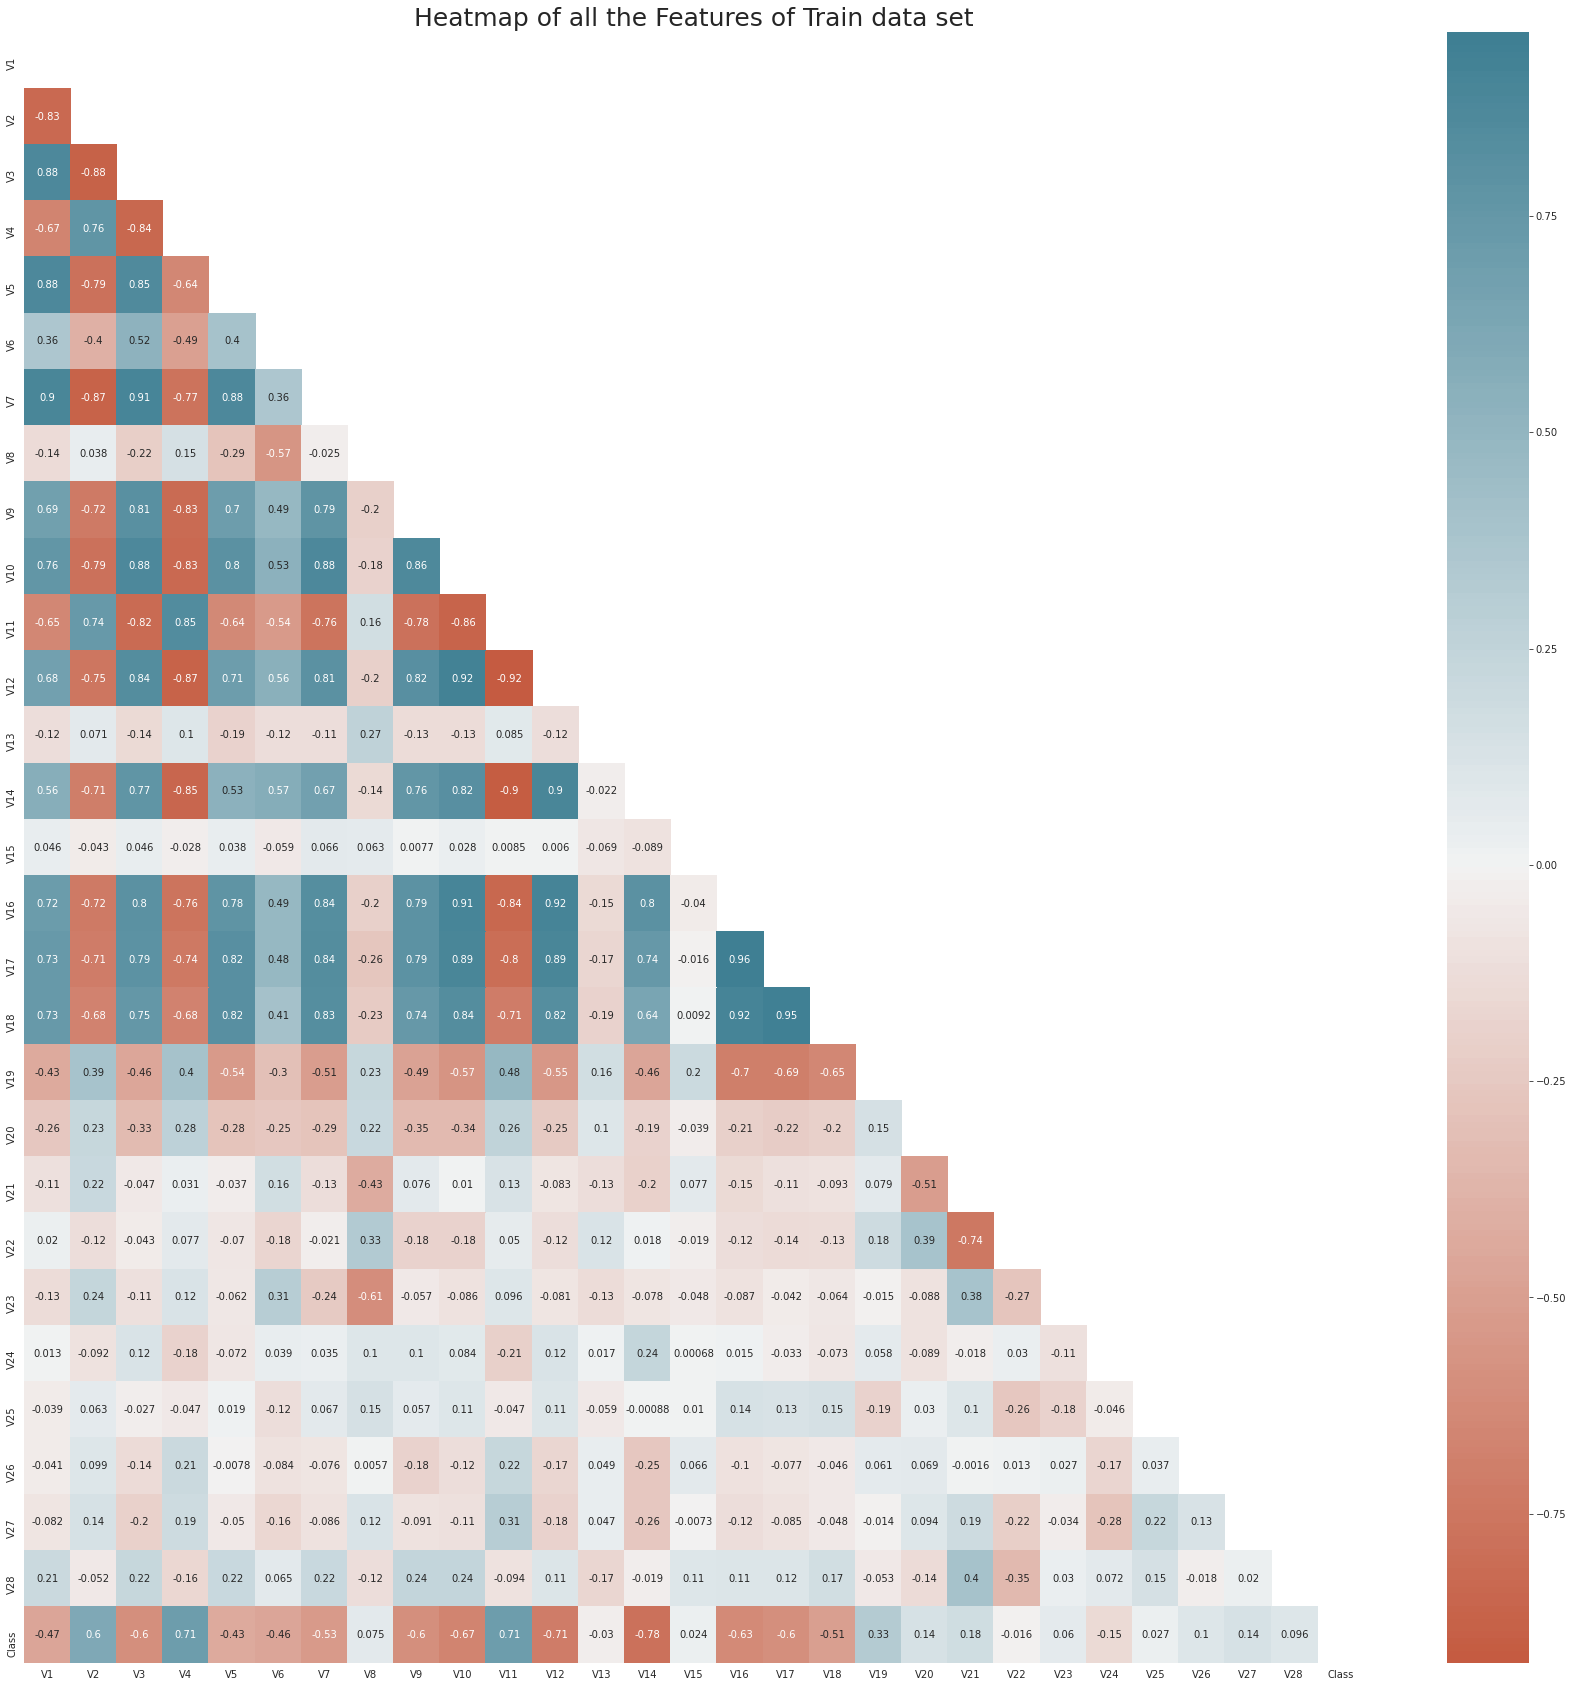

In [ ]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,30))
## Plotting heatmap. Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, );
plt.title("Heatmap of all the Features of Train data set", fontsize = 25)

undersampled data와 비교하자면, 보다 상관성이 안정적이어졌다. 

In [ ]:
X_ov_train, X_ov_test, y_ov_train, y_ov_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=2)

In [ ]:
model.fit(X_ov_train,y_ov_train)
y_pred = model.predict(X_ov_test)

accuracy = accuracy_score(y_ov_test, y_pred)
print("Accuracy: %.3f%%" % (accuracy))

Accuracy: 0.961%


데이터의 수가 늘어나니, Accuracy score도 보다 안정적이어졌다. 

In [ ]:
print(classification_report(y_ov_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2857
           1       0.97      0.95      0.96      2823

    accuracy                           0.96      5680
   macro avg       0.96      0.96      0.96      5680
weighted avg       0.96      0.96      0.96      5680



또란, precision, recall, f-score 모두 큰 폭으로 성능이 좋아졌다! 이는 앞선 가설인 "성능의 문제는 데이터의 부족에서 기인한다"가 맞았음을 의미한다. 

In [ ]:
# confusion_matrix
confusion_matrix(y_ov_test,y_pred)

array([[2779,   78],
       [ 145, 2678]])

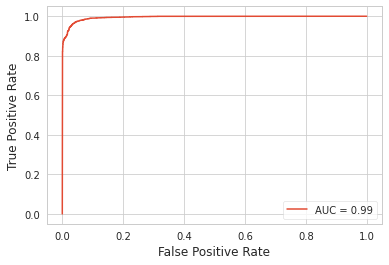

In [ ]:
generate_auc_roc_curve(model, X_ov_test, y_ov_test)

ROC-AUC 값도 크게 좋아졌다. 다시 말해, 해당 Logistic Regression을 이용한 분석을 위해서는 1) 데이터의 균형 2) 데이터의 크기를 고려해야했다. 